### Iris dataset, steg för steg

In the whole exercise, we will work with the famous Iris flower dataset, which was collected in 1936 by Ronald Fisher, a statistician and biologist.   
Use the datasets module from scikit-learn to load the iris dataset.

  a) Check keys on the loaded data and check what the different values for each key are.

  b) Now insert the data into a DataFrame.

  c) Do some EDA to get an understanding of the dataset.

  d) Make a correlation heatmap to see how each feature is correlated to each other. What do the numbers mean?

  e) Make a boxplot. The points outside of the boxplot are statistically calculated outliers using Tukey's rule for boxplot.

  f) Now remove the outliers in data. (**)   
   - Lower bound outliner
   - Upper bound outliner

  g) Do train|test split on the dataset and then scale it with feature standardization.

  h) Classify using logistic regression

  i) Classify the first 10 values of your X_test and compare it manually with your labels.

  j) Evaluate your model using classification report and confusion matrix. Use elbow plot to choose an appropriate K.

In [ ]:
from sklearn.datasets import load_iris
import pandas as pd

iris = load_iris(as_frame=True) #Iris är ett bunch-objekt!

df = iris.frame.copy() #hämtar hem datan som en dataframe
# df = load_iris(as_frame = True).frame => Gör allt i ett steg

df["target_name"] = df["target"].map(dict(enumerate(iris.target_names)))

df.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


---

### Steg 1 — välj vilka kolumner som ska korreleras   

Varför? 
Target/target_name är etiketter, inte mätningar.   
Korrelationen ska bara göras på numeriska features.

In [14]:

feature_cols = iris.feature_names
feature_cols


['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

---

### Steg 2 — beräkna korrelationsmatrisen (Pearson r)
Varför?   
Vi vill se hur starkt varje feature samvarierar med varje annan feature.   
   
   Tumregel: ~0.7+ starkt, ~0.4–0.7 måttligt, ~0.2–0.4 svagt.

In [15]:
corr = df[feature_cols].corr(method = "pearson") #corr => data vi senare använder för att se korrelationen
corr.round(2) #för en snyggare utskrift

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.00,-0.12,0.87,0.82
sepal width (cm),-0.12,1.00,-0.43,-0.37
petal length (cm),0.87,-0.43,1.00,0.96
petal width (cm),0.82,-0.37,0.96,1.00


--------------------------------

### Steg 3: rita heatmap (Seaborn)
Varför?   
Lättare att se mönster än i ren tabell.   
   
Vad du (ofta) ser i Iris:

- Petal length & petal width: hög positiv korrelation (nära 1).

- Sepal width korrelerar svagare och ibland negativt med vissa petal-mått.

- Diagonalen är alltid 1.00 (en feature med sig själv).

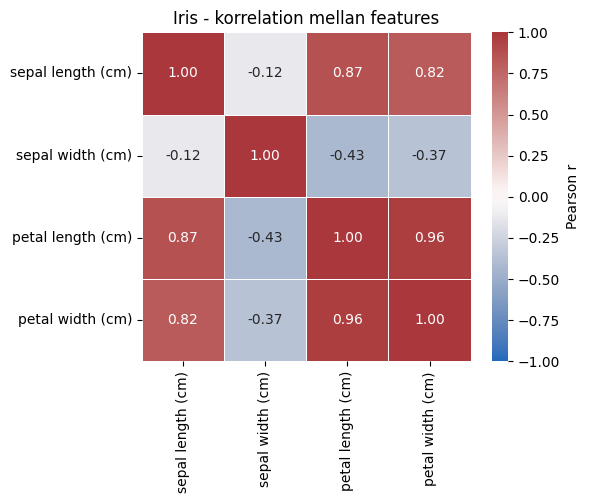

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

sns.heatmap(
    corr,               # data att rita
    annot=True,         # skriv siffror i rutorna
    fmt=".2f",          # två decimaler
    cmap="vlag",        # färgskala centrerad runt 0
    vmin=-1, vmax=1,    # lås skalan till [-1, 1]
    square=True,        # rutor blir kvadratiska
    linewidths=0.5,     # tunna linjer mellan rutor
    cbar_kws={"label": "Pearson r"}  # etikett på färgbar
)
plt.title("Iris - korrelation mellan features")
plt.tight_layout()
plt.show()

### Vanliga missar (och hur du undviker dem)

- Råka ta med target / target_name i korrelationen → håll dig till feature_cols.

- Blandade datatyper i kolumner → se till att features är numeriska (float/int).

- Otydliga kolumnnamn → du kan byta namn om du vill, men det behövs inte för att heatmapen ska funka.

------------------------------------------------------------------------------------------------

### Steg 4: rita boxplot 

En  feature i taget

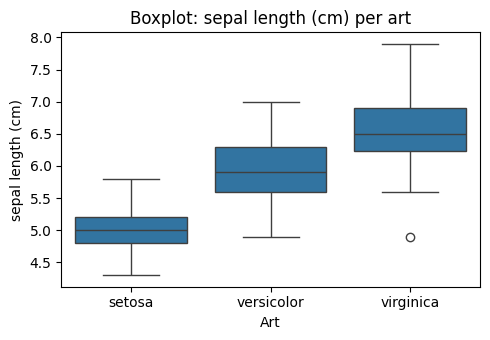

In [17]:
plt.figure(figsize=(5, 3.5))        # Skapar en ny figur (canvas) och sätter storlek i tum: bredd=5, höjd=3.5

sns.boxplot(                         # Ritar själva boxploten
    data=df,                         # DataFrame som innehåller både features och target_name
    x="target_name",                 # Kategorisk axel (x): arterna/grupperna att jämföra
    y=feature_cols[0]                # Numerisk axel (y): den feature vi vill visa fördelningen av
)

plt.title(f"Boxplot: {feature_cols[0]} per art")    # Titel över figuren
plt.xlabel("Art")                                   # Etikett på x-axeln (OBS: detta är en FUNKTIONSANROP)
plt.ylabel(feature_cols[0])                         # Etikett på y-axeln (också funktionsanrop)
plt.tight_layout()                                  # Fixar layout så att etiketter/titlar inte klipps
plt.show()                                          # Renderar/visar figuren i notebook


Alla fyra features (facetterad)

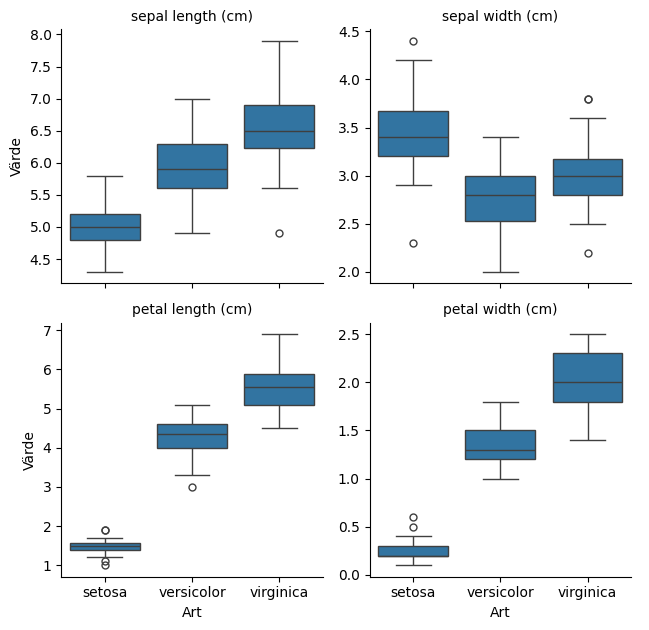

<Figure size 640x480 with 0 Axes>

In [18]:
# Gör datan "lång" (melt) så varje rad blir (art, feature, värde)
long_df = df.melt(
    id_vars="target_name",            # Kolumn som beskriver gruppering (x-axel): arten
    value_vars=feature_cols,          # Vilka kolumner (features) vi vill rita
    var_name="feature",               # Ny kolumn som talar om vilken feature varje rad tillhör
    value_name="value"                # Ny kolumn som innehåller mätvärdet
)

# Rita boxplots i ett facet-grid (en panel/kolumn per feature)
g = sns.catplot(
    data=long_df,                     # Den "långa" tabellen
    x="target_name",                  # Kategorier på x-axeln (arterna)
    y="value",                        # Numeriskt värde på y-axeln
    col="feature",                    # Skapa en separat panel för varje feature
    kind="box",                       # Rita boxplot
    col_wrap=2,                       # Bryt till 2 paneler per rad (så det blir 2x2)
    sharey=False,                     # Låt varje panel ha egen y-skala (gör jämförelser inom panel tydligare)
    height=3.2                        # Höjd (tum) per panel; bredd räknas ut automatiskt
)

g.set_axis_labels("Art", "Värde")     # Sätter gemensamma axel-etiketter för alla paneler
g.set_titles("{col_name}")            # Panelernas rubriker blir feature-namnen
plt.tight_layout()                    # Fixar layout så inget klipps
plt.show()                            # Visar figuren


for ax, feat in zip(g.axes.flatten(), long_df["feature"].unique()):
    sns.stripplot(
        data=long_df[long_df["feature"] == feat],  # Endast rader för aktuell feature
        x="target_name", y="value",
        ax=ax,                                      # Rita prickarna i rätt panel
        alpha=0.5,                                  # Halvtransparenta prickar (syns ovanpå boxen utan att bli plottrigt)
        color="k",                                  # Svart färg på prickarna
        size=2                                      # Små prickar (passar många punkter)
    )

g.set_axis_labels("Art", "Värde")     # Sätt axel-etiketter igen för denna figur
g.set_titles("{col_name}")            # Panelrubriker = feature-namn
plt.tight_layout()                    # Fixar layout
plt.show()                            # Visar figuren

---------------------------------------------------------------------------------------------

### Moment 1 — Q1, Q3, IQR och tukey-gränser för EN feature

In [19]:
feature_name = "sepal length (cm)" #Väljer en feature att analysera

q1 = df[feature_name].quantile(0.25)   # 25:e percentilen
q3 = df[feature_name].quantile(0.75)   # 75:e percentilen

iqr = q3 - q1 # => Interquartile range (IQR)

lower_bound = q1 - 1.5 * iqr # => Tukey-gränser
upper_bound = q3 + 1.5 *iqr

print("Feature:", feature_name)
print(f"Q1  (25%): {q1:.3f}")
print(f"Q3  (75%): {q3:.3f}")
print(f"IQR      : {iqr:.3f}")
print(f"Lower    : {lower_bound:.3f}  (Q1 - 1.5*IQR)")
print(f"Upper    : {upper_bound:.3f}  (Q3 + 1.5*IQR)")


Feature: sepal length (cm)
Q1  (25%): 5.100
Q3  (75%): 6.400
IQR      : 1.300
Lower    : 3.150  (Q1 - 1.5*IQR)
Upper    : 8.350  (Q3 + 1.5*IQR)


### Moment 2 - Flagga outliers för en vald feature

In [20]:
feature_name = "sepal length (cm)"
group_col = "target_name"               #=> grupperingen (x-axeln i boxploten)

q1 = df.groupby(group_col)[feature_name].quantile(0.25)
q3 = df.groupby(group_col)[feature_name].quantile(0.75)

iqr = q3 - q1
low = q1 - 1.5 * iqr
high = q3 + 1.5 * iqr

bounds = pd.DataFrame({"Q1": q1, "Q3": q3, "IQR": iqr, "lower": low, "upper": high})
print("Tukey-gränserna per art: \n")
display(bounds.round(3))


tmp = df[[group_col, feature_name]].join(bounds, on=group_col)
is_outlier_grp = (tmp[feature_name]< tmp["lower"]) | (tmp[feature_name] > tmp["upper"])

print("\nAntal outliwers per art: ")
print(tmp[is_outlier_grp].groupby(group_col).size())

print("\nSjälva raderna som flaggats (sorterade):")
display(tmp[is_outlier_grp].sort_values([group_col, feature_name]))

Tukey-gränserna per art: 



,Q1,Q3,IQR,lower,upper
target_name,,,,,
setosa,4.800,5.2,0.400,4.200,5.800
versicolor,5.600,6.3,0.700,4.550,7.350
virginica,6.225,6.9,0.675,5.212,7.913



Antal outliwers per art: 
target_name
virginica    1
dtype: int64

Själva raderna som flaggats (sorterade):


,target_name,sepal length (cm),Q1,Q3,IQR,lower,upper
106,virginica,4.9,6.225,6.9,0.675,5.2125,7.9125


--------


### Moment 4A: bygg en “drop-mask” för att SE vilka rader som skulle tas bort

In [21]:

feature_name = "sepal length (cm)"
group_col = "target_name"

q1 = df.groupby(group_col)[feature_name].quantile(0.25)
q3 = df.groupby(group_col)[feature_name].quantile(0.75)

iqr = q3 - q1

bounds = pd.DataFrame({
    "lower": q1 -1.5 * iqr,
    "upper": q3 + 1.5 * iqr
})

tmp = df[[group_col, feature_name]].join(bounds, on= group_col)
mask_keep = (tmp[feature_name] >= tmp["lower"]) & (tmp[feature_name] <= tmp["upper"])

n_total = len(df)
n_keep  = int(mask_keep.sum())
n_drop  = n_total - n_keep
print(f"Feature: {feature_name}")
print(f"Totalt: {n_total} | Behåll: {n_keep} | Skulle tas bort: {n_drop}")

print("\nDrop per art:")
print(df.loc[~mask_keep, group_col].value_counts())

cols_to_show = ["target_name", feature_name]
display(df.loc[~mask_keep, cols_to_show].sort_values([group_col, feature_name]).head(10))

Feature: sepal length (cm)
Totalt: 150 | Behåll: 149 | Skulle tas bort: 1

Drop per art:
target_name
virginica    1
Name: count, dtype: int64


,target_name,sepal length (cm)
106,virginica,4.9


### Moment 4B = Filtrera bort outliers (för en vald feature, per art), och skapa en ny DataFrame utan att röra originalet.

In [22]:
df_clean = df[mask_keep].reset_index(drop=True)   # ändrar INTE df, skapar ny DataFrame

print(f"Före: {len(df)} rader")
print(f"Efter: {len(df_clean)} rader")
print(f"Borttagna: {len(df) - len(df_clean)} rader")


print("\nRader per art — före:")                # => Sanity check: hur ser art-fördelningen ut före/efter?
print(df["target_name"].value_counts())

print("\nRader per art — efter:")
print(df_clean["target_name"].value_counts())


Före: 150 rader
Efter: 149 rader
Borttagna: 1 rader

Rader per art — före:
target_name
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

Rader per art — efter:
target_name
setosa        50
versicolor    50
virginica     49
Name: count, dtype: int64


### Moment 4C = Ta bort outliers om en rad är outlier i någon av de fyra features (per art, enligt Tukey)

In [23]:

# --- 4C. Förbered feature-listan (om du inte redan har den) ---
if 'feature_cols' not in locals():
    exclude = {"target", "target_name", "Id"}
    num_cols = df.select_dtypes(include="number").columns
    feature_cols = [c for c in num_cols if c not in exclude]
print("Features som kontrolleras:", feature_cols)

group_col = "target_name"   # per art (samma logik som boxplot)

# --- 4C.1 Beräkna Tukey-gränser per ART och per FEATURE ---
# Vi bygger en tabell med lower/upper för varje (art, feature)
bounds_dict = {}
for feat in feature_cols:
    q1 = df.groupby(group_col)[feat].quantile(0.25)
    q3 = df.groupby(group_col)[feat].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    bounds_dict[feat] = pd.DataFrame({"lower": lower, "upper": upper})

# --- 4C.2 Flagga outliers per FEATURE (per art) ---
# Skapar en DataFrame 'flags' med en bool-kolumn per feature: True = outlier
flags = pd.DataFrame(index=df.index)
for feat in feature_cols:
    tmp = df[[group_col, feat]].join(bounds_dict[feat], on=group_col)
    flags[feat] = (tmp[feat] < tmp["lower"]) | (tmp[feat] > tmp["upper"])

# --- 4C.3 Kombinera flaggor över alla features ---
any_outlier = flags.any(axis=1)          # True om outlier i MINST EN feature
mask_keep_all = ~any_outlier             # behåll rader som INTE är outlier i någon feature

# --- 4C.4 Sammanfattning innan vi faktiskt filtrerar ---
n_total = len(df)
n_drop  = int(any_outlier.sum())
n_keep  = n_total - n_drop
print(f"Totalt: {n_total} | Skulle tas bort (outlier i någon feature): {n_drop} | Behåll: {n_keep}")

print("\nBorttagna per art (förhandsvisning):")
print(df.loc[any_outlier, group_col].value_counts())

print("\nFörsta rader som skulle tas bort (med vilka features som slog ut):")
to_show = df.loc[any_outlier, [group_col] + feature_cols].copy()
to_show["outlier_features"] = flags.loc[any_outlier].apply(lambda r: [c for c,v in r.items() if v], axis=1)
display(to_show.sort_values([group_col] + feature_cols).head(10))


Features som kontrolleras: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Totalt: 150 | Skulle tas bort (outlier i någon feature): 13 | Behåll: 137

Borttagna per art (förhandsvisning):
target_name
setosa        8
virginica     4
versicolor    1
Name: count, dtype: int64

Första rader som skulle tas bort (med vilka features som slog ut):


,target_name,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),outlier_features
13,setosa,4.3,3.0,1.1,0.1,[petal length (cm)]
41,setosa,4.5,2.3,1.3,0.3,[sepal width (cm)]
22,setosa,4.6,3.6,1.0,0.2,[petal length (cm)]
24,setosa,4.8,3.4,1.9,0.2,[petal length (cm)]
43,setosa,5.0,3.5,1.6,0.6,[petal width (cm)]
23,setosa,5.1,3.3,1.7,0.5,[petal width (cm)]
44,setosa,5.1,3.8,1.9,0.4,[petal length (cm)]
15,setosa,5.7,4.4,1.5,0.4,[sepal width (cm)]
98,versicolor,5.1,2.5,3.0,1.1,[petal length (cm)]
106,virginica,4.9,2.5,4.5,1.7,[sepal length (cm)]


### Moment 4D = Skapa den “rensade” DataFrame:n och sanity-checka resultatet.

In [24]:

# 1) Skapa en ny, ren DataFrame (ändrar INTE originalet df)
df_clean_all = df[mask_keep_all].reset_index(drop=True)

print(f"Före rensning: {len(df)} rader")
print(f"Efter rensning: {len(df_clean_all)} rader")
print(f"Borttagna totalt: {len(df) - len(df_clean_all)} rader")

# 2) Klassbalans före/efter (viktigt sanity check)
print("\nRader per art — FÖRE:")
print(df["target_name"].value_counts())

print("\nRader per art — EFTER:")
print(df_clean_all["target_name"].value_counts())

# 3) (Valfritt) Snabb jämförelse av statistik före/efter
exclude = {"target", "target_name", "Id"}
num_cols = df.select_dtypes(include="number").columns
feature_cols = [c for c in num_cols if c not in exclude]

print("\nBeskrivande statistik — FÖRE:")
display(df[feature_cols].describe().T.round(3))

print("\nBeskrivande statistik — EFTER:")
display(df_clean_all[feature_cols].describe().T.round(3))

# 4) Verifiera att inga Tukey-outliers återstår (per art, per feature)
import pandas as pd

def tukey_flags_per_group(data, group_col, feats):
    bounds_dict = {}
    for feat in feats:
        q1 = data.groupby(group_col)[feat].quantile(0.25)
        q3 = data.groupby(group_col)[feat].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5*iqr
        upper = q3 + 1.5*iqr
        bounds_dict[feat] = pd.DataFrame({"lower": lower, "upper": upper})
    flags = pd.DataFrame(index=data.index)
    for feat in feats:
        tmp = data[[group_col, feat]].join(bounds_dict[feat], on=group_col)
        flags[feat] = (tmp[feat] < tmp["lower"]) | (tmp[feat] > tmp["upper"])
    return flags

flags_after = tukey_flags_per_group(df_clean_all, "target_name", feature_cols)
n_outliers_after = int(flags_after.any(axis=1).sum())
print(f"\nVerifiering: antal outliers kvar efter rensning: {n_outliers_after}")


Före rensning: 150 rader
Efter rensning: 137 rader
Borttagna totalt: 13 rader

Rader per art — FÖRE:
target_name
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

Rader per art — EFTER:
target_name
versicolor    49
virginica     46
setosa        42
Name: count, dtype: int64

Beskrivande statistik — FÖRE:


,count,mean,std,min,25%,50%,75%,max
sepal length (cm),150.0,5.843,0.828,4.3,5.1,5.80,6.4,7.9
sepal width (cm),150.0,3.057,0.436,2.0,2.8,3.00,3.3,4.4
petal length (cm),150.0,3.758,1.765,1.0,1.6,4.35,5.1,6.9
petal width (cm),150.0,1.199,0.762,0.1,0.3,1.30,1.8,2.5



Beskrivande statistik — EFTER:


,count,mean,std,min,25%,50%,75%,max
sepal length (cm),137.0,5.882,0.787,4.4,5.2,5.8,6.4,7.7
sepal width (cm),137.0,3.040,0.404,2.0,2.8,3.0,3.3,4.2
petal length (cm),137.0,3.840,1.722,1.2,1.6,4.4,5.1,6.9
petal width (cm),137.0,1.231,0.759,0.1,0.3,1.3,1.8,2.5



Verifiering: antal outliers kvar efter rensning: 11


----------

### Steg 5 - Dela upp data - Train | Test-split

In [25]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [26]:
exclude = {"target", "target_name"}
num_cols = df.select_dtypes(include="number").columns
feature_cols = [c for c in num_cols if c not in exclude]

feature_cols

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [28]:
X = df[feature_cols].values
y = df["target"].values



In [34]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size= 0.33, random_state=42, stratify=y
)

X_train.shape, X_train.shape, y_train.shape, y_train.shape


((100, 4), (100, 4), (100,), (100,))

In [35]:
from matplotlib.pylab import multinomial
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(multi_class="multinomial", solver= "lbfgs", max_iter=500))

])

pipe

,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


---------


### Steg 6 - Träna logistisk regression

In [36]:
pipe.fit(X_train, y_train)               # tränar scaler + modell på TRAIN
train_acc = pipe.score(X_train, y_train) # accuracy på train (snabb koll)
test_acc  = pipe.score(X_test, y_test)   # accuracy på test (viktigast)
print(f"Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Train acc: 0.980 | Test acc: 0.920


c:\Users\susan\KodPython\ai_engineering_susanne_wenblad\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [38]:
import numpy as np
class_names = ["setosa","versicolor","virginica"]

y_pred  = pipe.predict(X_test)
proba   = pipe.predict_proba(X_test)   # softmax-sannolikheter per klass
top_p   = np.max(proba, axis=1)        # högsta sannolikheten per rad

first = 10
compare = pd.DataFrame({
    "True": [class_names[i] for i in y_test[:first]],
    "Pred": [class_names[i] for i in y_pred[:first]],
    "P(max)": top_p[:first].round(3)
})
compare

,True,Pred,P(max)
0,virginica,versicolor,0.616
1,versicolor,versicolor,0.600
2,setosa,setosa,0.973
3,versicolor,versicolor,0.934
4,virginica,virginica,0.885
5,versicolor,versicolor,0.875
6,versicolor,versicolor,0.842
7,setosa,setosa,0.973
8,versicolor,versicolor,0.702
9,versicolor,versicolor,0.914


Classification report:

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        16
  versicolor       0.84      0.94      0.89        17
   virginica       0.93      0.82      0.88        17

    accuracy                           0.92        50
   macro avg       0.93      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50



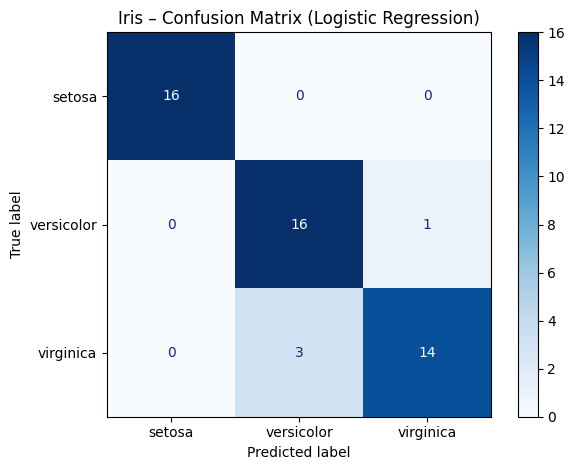

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("Classification report:\n")
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.title("Iris – Confusion Matrix (Logistic Regression)")
plt.tight_layout()
plt.show()


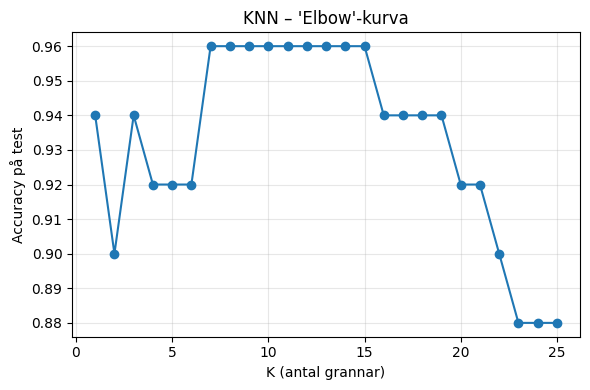

Bästa K enligt test-accuracy: 7  (accuracy = 0.96 )


In [40]:
from sklearn.neighbors import KNeighborsClassifier

ks = range(1, 26)
scores = []
for k in ks:
    knn_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])
    knn_pipe.fit(X_train, y_train)
    scores.append(knn_pipe.score(X_test, y_test))   # test-accuracy per K

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(list(ks), scores, marker="o")
plt.xlabel("K (antal grannar)")
plt.ylabel("Accuracy på test")
plt.title("KNN - 'Elbow'-kurva")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

best_k = list(ks)[int(np.argmax(scores))]
print("Bästa K enligt test-accuracy:", best_k, " (accuracy =", max(scores), ")")